Machine learning model testing space

In [2]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

from scipy.stats.mstats import winsorize
from scipy.stats import zscore, stats
from math import ceil

# ml modules
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor


from sklearn import ensemble
from sklearn.model_selection import cross_val_score, train_test_split

import statsmodels
import statsmodels.api as sm

from sklearn.svm import SVR

In [3]:
# read in 990 data that has been
# subsetted and cleaned in 990_cont_comp_EDA notebook
df = pd.read_csv('data/990_model_data.csv')

In [4]:
df.shape

(27360, 113)

In [63]:
df.head()

,ein,name_org,tax_date_begin,tax_date_end,tax_yr,doing_business_as,phone,website,address,city,state,country,zip,org_form.corp,org_form.trust,org_form.association,org_form.other_form,org_form.other_form_desc,formation_yr,grp_exempt_num,state_legaldomicile,grp_return,grp_subs_all_incl,exempt_status.501c3,exempt_status.501c_any,exempt_status.501c_txt,gross_receipts,discontinue_dispose25,voting_memb_ct,voting_indepmemb_ct,employee_tot_ct,volunteer_tot_ct,income_tot_unrelated,income_net_unrelated,rev_giftsgrants_tot_prioryr,rev_prgmservice_prioryr,rev_investmt_prioryr,rev_other_prioryr,rev_tot_prioryr,grants_expense_tot_prioryr,benefits_expense_tot_prioryr,salaries_expense_tot_prioryr,fundraiseservfee_expense_tot_prioryr,fundraise_expense_tot_curyr,other_expense_tot_prioryr,expense_tot_prioryr,rev_less_expense_prioryr,asset_tot_beginyr,liability_tot_beginyr,asset_net_beginyr,rev_giftsgrants_tot_curyr,rev_prgmservice_curyr,rev_investmt_curyr,rev_other_curyr,rev_tot_curyr,grants_expense_tot_curyr,benefits_expense_tot_curyr,salaries_expense_tot_curyr,fundraiseservfee_expense_tot_curyr,other_expense_tot_curyr,expense_tot_curyr,rev_less_expense_curyr,asset_tot_endyr,liability_tot_endyr,asset_net_endyr,name_contractor_1,address_contractor_1,city_contractor_1,state_contractor_1,zip_contractor_1,country_contractor_1,services_contractor_1,amt_paid_contractor_1,name_contractor_2,address_contractor_2,city_contractor_2,state_contractor_2,zip_contractor_2,country_contractor_2,services_contractor_2,amt_paid_contractor_2,name_contractor_3,address_contractor_3,city_contractor_3,state_contractor_3,zip_contractor_3,country_contractor_3,services_contractor_3,amt_paid_contractor_3,name_contractor_4,address_contractor_4,city_contractor_4,state_contractor_4,zip_contractor_4,country_contractor_4,services_contractor_4,amt_paid_contractor_4,name_contractor_5,address_contractor_5,city_contractor_5,state_contractor_5,zip_contractor_5,country_contractor_5,services_contractor_5,amt_paid_contractor_5,contractor_100k_ct,record_id,schema_version,irs_efile_id,random_string,con_ct_div_emp_ct,con_ct_div_exp,sal_exp_div_tot_exp
0,10056837,EASTERN MAINE ELECTRIC COOPERATIVE INC,2016-01-01,2016-12-31,2016,NaN,+1 (207) 454-7555,www.emec.com,PO Box 425,Calais,ME,NaN,046190425,True,NaN,NaN,NaN,NaN,1940.0,NaN,ME,no,NaN,False,True,12.0,15549792,NaN,11,11,37,0.0,0,0.0,0.0,15540869.0,280449.0,0.0,15821318.0,0.0,352726.0,1774024.0,0.0,0,13694568.0,15821318.0,0.0,39372255.0,26541056.0,12831199.0,0,15214173,335619,0,15549792,0,-242865,1753677,0,14038980,15549792,0,39367859,26785093,12582766,Lucas Tree Experts,PO Box 958,Portland,ME,04104,NaN,Tree Clearing Work,144757.0,Preti Flaherty Beliveau Pachios LLP,PO Box 9546,Portland,ME,04112,NaN,Legal,284923.0,On Target Utility Services,617 Water St,Gardiner,ME,04345,NaN,Utility Construction,526681.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,010056837_201612,2016v3.0,201722499349300607,NTk1ODY4MDk3ODk3NjYyMDY2OQ,0.050847,1.929286e-07,0.112778
1,10079380,CPORT CREDIT UNION,2016-01-01,2016-12-31,2016,NaN,+1 (207) 878-6200,WWW.CPORTCU.ORG,PO BOX 777,PORTLAND,ME,NaN,04104,True,NaN,NaN,NaN,NaN,1931.0,NaN,ME,no,NaN,False,True,14.0,9472036,NaN,9,8,81,8.0,52565,-75519.0,0.0,8093378.0,128192.0,162461.0,8384031.0,0.0,850819.0,3076199.0,0.0,0,3456770.0,7383788.0,1000243.0,173898488.0,157544120.0,16354368.0,0,9089872,158726,223438,9472036,0,752626,3404135,0,4052976,8209737,1262299,188534687,170915216,17619471,SYNERGENT,2 LEDGEVIEW DRIVE,WESTBROOK,ME,04092,NaN,CORE PROCESSING AND RELATED SERVICES,806186.0,SYSTEMS ENGINEERING,120 EXCHANGE STREET,PORTLAND,ME,04101,NaN,INFORMATION TECH. SERVICES,171160.0,PM SYSTEMS (ACI WORLDWIDE CORP),99944 COLLECTION CENTER DR,CHICAGO,IL,60693,NaN,ONLINE BANKING PROVIDER,147655.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,010079380_201612,2016v3.0,201713179349301261,NTAxNDUzNjQ4MzgwNDIzMTg2MA,0.028302,3.654197e-07,0.414646
2,10114035,Maine Education Association,2015-

#### Clean data

In [5]:
# for org_forms
# fill nans with False

for column in list(df.loc[:,'org_form.corp' : 'org_form.other_form'].columns):
    df[column].fillna(False, inplace=True)

In [6]:
# formation year has a number of NaN values
# Convert these to None to be able to encode properly

df.loc[df.formation_yr.isna(), 'formation_yr'] = 'None'

In [7]:
# verify none remain
df[df.formation_yr.isna()].shape

(0, 113)

In [21]:
# convert data type of exempt_status.501c_txt to object
# to be able to categorize this column
df['exempt_status.501c_txt'] = df['exempt_status.501c_txt'].apply(int).apply(str)

#### Remove unnecessary columns

In [8]:
# drop columns at beginning of dataset
df.drop(df.loc[:,'ein': 'zip'].columns, axis=1, inplace=True)

# drop columns at end of dataset
df.drop(df.loc[:,'record_id': 'random_string'].columns, axis=1, inplace=True)

In [9]:
# drop other misc columns
df.drop(['org_form.other_form_desc', 'grp_exempt_num', 'grp_return', 'grp_subs_all_incl'], axis=1, inplace=True)

# drop other misc columns
# df.drop(['grp_return', 'grp_subs_all_incl'], axis=1, inplace=True)

In [10]:
# drop specific contractor info
# these will have a lot of nans for contractors 2, 3, 4, 5
# also the categories of services provided by 
# various vendors are very messy

df.drop(df.loc[:,'name_contractor_1': 'amt_paid_contractor_5'].columns, axis=1, inplace=True)

In [23]:
df.shape

(27360, 355)

In [25]:
# convert categories to dummies
df = pd.get_dummies(df)

In [28]:
df.shape

(27360, 373)

In [27]:
df.head()

,org_form.corp,org_form.trust,org_form.association,org_form.other_form,exempt_status.501c3,gross_receipts,voting_memb_ct,voting_indepmemb_ct,employee_tot_ct,volunteer_tot_ct,income_tot_unrelated,income_net_unrelated,rev_giftsgrants_tot_prioryr,rev_prgmservice_prioryr,rev_investmt_prioryr,rev_other_prioryr,rev_tot_prioryr,grants_expense_tot_prioryr,benefits_expense_tot_prioryr,salaries_expense_tot_prioryr,fundraiseservfee_expense_tot_prioryr,fundraise_expense_tot_curyr,other_expense_tot_prioryr,expense_tot_prioryr,rev_less_expense_prioryr,asset_tot_beginyr,liability_tot_beginyr,asset_net_beginyr,rev_giftsgrants_tot_curyr,rev_prgmservice_curyr,rev_investmt_curyr,rev_other_curyr,rev_tot_curyr,grants_expense_tot_curyr,benefits_expense_tot_curyr,salaries_expense_tot_curyr,fundraiseservfee_expense_tot_curyr,other_expense_tot_curyr,expense_tot_curyr,rev_less_expense_curyr,asset_tot_endyr,liability_tot_endyr,asset_net_endyr,contractor_100k_ct,con_ct_div_emp_ct,con_ct_div_exp,sal_exp_div_tot_exp,formation_yr_1645.0,formation_yr_1650.0,formation_yr_1660.0,formation_yr_1689.0,formation_yr_1701.0,formation_yr_1709.0,formation_yr_1740.0,formation_yr_1746.0,formation_yr_1749.0,formation_yr_1751.0,formation_yr_1754.0,formation_yr_1759.0,formation_yr_1763.0,formation_yr_1764.0,formation_yr_1765.0,formation_yr_1766.0,formation_yr_1769.0,formation_yr_1772.0,formation_yr_1774.0,formation_yr_1778.0,formation_yr_1780.0,formation_yr_1781.0,formation_yr_1782.0,formation_yr_1783.0,formation_yr_1784.0,formation_yr_1785.0,formation_yr_1787.0,formation_yr_1789.0,formation_yr_1791.0,formation_yr_1792.0,formation_yr_1793.0,formation_yr_1794.0,formation_yr_1795.0,formation_yr_1797.0,formation_yr_1798.0,formation_yr_1799.0,formation_yr_1800.0,formation_yr_1801.0,formation_yr_1802.0,formation_yr_1805.0,formation_yr_1806.0,formation_yr_1807.0,formation_yr_1808.0,formation_yr_1809.0,formation_yr_1810.0,formation_yr_1811.0,formation_yr_1812.0,formation_yr_1813.0,formation_yr_1814.0,formation_yr_1815.0,formation_yr_1816.0,formation_yr_1817.0,formation_yr_1818.0,formation_yr_1819.0,formation_yr_1820.0,formation_yr_1821.0,formation_yr_1823.0,formation_yr_1824.0,formation_yr_1825.0,formation_yr_1826.0,formation_yr_1827.0,formation_yr_1828.0,formation_yr_1829.0,formation_yr_1830.0,formation_yr_1831.0,formation_yr_1832.0,formation_yr_1833.0,formation_yr_1834.0,formation_yr_1835.0,formation_yr_1836.0,formation_yr_1837.0,formation_yr_1838.0,formation_yr_1839.0,formation_yr_1840.0,formation_yr_1841.0,formation_yr_1842.0,formation_yr_1843.0,formation_yr_1844.0,formation_yr_1845.0,formation_yr_1846.0,formation_yr_1847.0,formation_yr_1848.0,formation_yr_1849.0,formation_yr_1850.0,formation_yr_1851.0,formation_yr_1852.0,formation_yr_1853.0,formation_yr_1854.0,formation_yr_1855.0,formation_yr_1856.0,formation_yr_1857.0,formation_yr_1858.0,formation_yr_1859.0,formation_yr_1860.0,formation_yr_1861.0,formation_yr_1862.0,formation_yr_1863.0,formation_yr_1864.0,formation_yr_1865.0,formation_yr_1866.0,formation_yr_1867.0,formation_yr_1868.0,formation_yr_1869.0,formation_yr_1870.0,formation_yr_1871.0,formation_yr_1872.0,formation_yr_1873.0,formation_yr_1874.0,formation_yr_1875.0,formation_yr_1876.0,formation_yr_1877.0,formation_yr_1878.0,formation_yr_1879.0,formation_yr_1880.0,formation_yr_1881.0,formation_yr_1882.0,formation_yr_1883.0,formation_yr_1884.0,formation_yr_1885.0,formation_yr_1886.0,formation_yr_1887.0,formation_yr_1888.0,formation_yr_1889.0,formation_yr_1890.0,formation_yr_1891.0,formation_yr_1892.0,formation_yr_1893.0,formation_yr_1894.0,formation_yr_1895.0,formation_yr_1896.0,formation_yr_1897.0,formation_yr_1898.0,formation_yr_1899.0,formation_yr_1900.0,formation_yr_1901.0,formation_yr_1902.0,formation_yr_1903.0,formation_yr_1904.0,formation_yr_1905.0,formation_yr_1906.0,formation_yr_1907.0,formation_yr_1908.0,formation_yr_1909.0,formation_yr_1910.0,formation_yr_1911.0,formation_yr_1912.0,formation_yr_1913.0,formation_yr_1914.0,formation_yr_1915.0,formation_yr_1916.

### OLS Regression - start with this, simply try to predict the number of contractors a not-for-profit org will have

In [29]:
# create target feature
y = df.contractor_100k_ct

# create testing features
X = df.drop('contractor_100k_ct', axis=1)

In [30]:
# create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [32]:
predictions = lrm.predict(X)
errors = y - predictions

print("Mean of the errors is: {}".format(np.mean(errors)))

Mean of the errors is: 0.043938614475381436


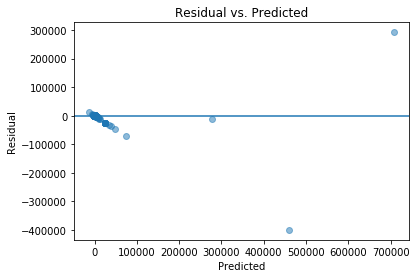

In [33]:
plt.scatter(predictions, errors, alpha=.5)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

Clearly, I've got some extreme outliers here.

In [34]:
# split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [35]:
lrm.fit(X_train, y_train) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [36]:
y_pred = lrm.predict(X_test)

In [37]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

-435.94480343204884

This seems to be wildly off, is this because of my outliers?

### Random Forrest - regressor

In [38]:
regr = RandomForestRegressor(max_depth=2, random_state=0)

regr.fit(X, y)
# cross_val_score(rfc, X, Y, cv=10)

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [39]:
cross_val_score(regr, X, y, cv=5)

array([-1.29600579e+02,  3.52264111e-02,  1.00216456e-01,  7.65246558e-02,
        1.26521655e-01])

results from this are terrible

In [40]:
f_importances = pd.DataFrame(regr.feature_importances_,
                            X.columns,
                            columns=['importance']).sort_values('importance', ascending=False)

In [41]:
f_importances.head(10)

,importance
con_ct_div_emp_ct,0.857230
expense_tot_curyr,0.069811
con_ct_div_exp,0.042767
formation_yr_1985.0,0.030189
rev_tot_curyr,0.000003
formation_yr_1966.0,0.000000
formation_yr_1973.0,0.000000
formation_yr_1972.0,0.000000
formation_yr_1971.0,0.000000
formation_yr_1970.0,0.000000


### Random Forrest Classifier - identify orgs with a high number of contractors and a low number of employees

In [164]:
# find the 90th percentile
q90 = np.percentile(df['con_ct_div_emp_ct'], [90])

q90[0]

0.1111111111111111

In [165]:
# what percent of the total does the 90th quartile make up?
df[df['con_ct_div_emp_ct'] > q90[0]].shape[0] / df.shape[0]

0.09923245614035088

In [42]:
# create flag column for orgs with 
# con_ct_div_emp_ct ratio equal or above 90th percentile
df['con_ct_div_emp_ct_FLAG'] = np.where(df['con_ct_div_emp_ct'] >= np.percentile(df['con_ct_div_emp_ct'],
                                                                               [90])[0], True, False)

In [43]:
# how many fall into each category?
df['con_ct_div_emp_ct_FLAG'].value_counts()

False    24511
True      2849
Name: con_ct_div_emp_ct_FLAG, dtype: int64

In [44]:
# create features for classification
X2 = df.drop('con_ct_div_emp_ct_FLAG', axis=1)

# create target for classification
y = df['con_ct_div_emp_ct_FLAG']

In [45]:
rfc = ensemble.RandomForestClassifier(n_estimators=100, max_depth=4)

rfc.fit(X2, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [46]:
cross_val_score(rfc, X2, y, cv=5)

array([0.91905719, 0.92653509, 0.90972222, 0.91849415, 0.93255346])

Given that my target feature makes up about 10% of the dataset, these aren't impressive results.

In [47]:
# examine importance of features
f_importances = pd.DataFrame(rfc.feature_importances_,
                            X2.columns,
                            columns=['importance']).sort_values('importance', ascending=False)

In [49]:
f_importances.head(20)

,importance
con_ct_div_emp_ct,0.213579
volunteer_tot_ct,0.087416
voting_indepmemb_ct,0.082754
employee_tot_ct,0.078723
voting_memb_ct,0.070698
sal_exp_div_tot_exp,0.050973
exempt_status.501c_txt_9,0.037848
salaries_expense_tot_curyr,0.037396
org_form.trust,0.032405
benefits_expense_tot_curyr,0.030663


### Support Vector Machines

In [157]:
svr = SVR()

svr.fit(X,y)

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


KeyboardInterrupt: 

In [ ]:
cross_val_score(svr, X, y, cv=5)

### Other Models to Follow